In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('../lumi.json') as f:
  lumis = json.load(f)

with open('../xsec.json') as f:
  xs = json.load(f)

with open('../pmap.json') as f:
  pmap = json.load(f)

ddbthr = 0.64

In [3]:
year='2016'
picklename = '../'+year+'/templates.pkl'
if not os.path.isfile(picklename):
    print("You need to create the pickle "+picklename)
else:
    templates = pickle.load(open(picklename,'rb')).sum('pt1').integrate('systematic','nominal').integrate('mjj',overflow='allnan')

In [4]:
x = templates.sum('genflavor','ddb1').integrate('region','signal-ggf')
x

<Hist (process,msd1) instance at 0x7f0107941100>

<AxesSubplot:xlabel='Jet $m_{sd}$', ylabel='Events'>

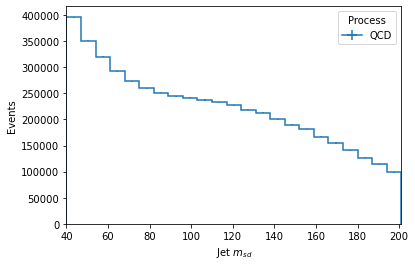

In [5]:
hist.plot1d(x,overlay='process')
#plt.yscale('log')
#plt.ylim(1,100000)

In [6]:
mc = ['QCD']
cutflow = pd.DataFrame(columns=['ggffail','ggfpass','vbffail','vbfpass'],index=mc)

In [7]:
for p in mc:
    print(p)
    if "Zjets" in p:
        continue
    
    cutflow['ggffail'][p] = templates.sum('msd1','genflavor').integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-ggf').integrate('process',p).values()[()]
    cutflow['ggfpass'][p] = templates.sum('msd1','genflavor').integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-ggf').integrate('process',p).values()[()]
    cutflow['vbffail'][p] = templates.sum('msd1','genflavor').integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-vbf').integrate('process',p).values()[()]
    cutflow['vbfpass'][p] = templates.sum('msd1','genflavor').integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-vbf').integrate('process',p).values()[()]
    
#cutflow['ggffail']['Zjets'] = templates.integrate('genflavor',int_range=slice(0,3)).integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-ggf').integrate('process','Zjets').values()[()]
#cutflow['ggfpass']['Zjets'] = templates.integrate('genflavor',int_range=slice(0,3)).integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-ggf').integrate('process','Zjets').values()[()]
#cutflow['vbffail']['Zjets'] = templates.integrate('genflavor',int_range=slice(0,3)).integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-vbf').integrate('process','Zjets').values()[()]
#cutflow['vbfpass']['Zjets'] = templates.integrate('genflavor',int_range=slice(0,3)).integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-vbf').integrate('process','Zjets').values()[()]

#cutflow['ggffail']['Zjetsbb'] = templates.integrate('genflavor',int_range=slice(3,4)).integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-ggf').integrate('process','Zjets').values()[()]
#cutflow['ggfpass']['Zjetsbb'] = templates.integrate('genflavor',int_range=slice(3,4)).integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-ggf').integrate('process','Zjets').values()[()]
#cutflow['vbffail']['Zjetsbb'] = templates.integrate('genflavor',int_range=slice(3,4)).integrate('ddb1',int_range=slice(0,ddbthr)).integrate('region','signal-vbf').integrate('process','Zjets').values()[()]
#cutflow['vbfpass']['Zjetsbb'] = templates.integrate('genflavor',int_range=slice(3,4)).integrate('ddb1',int_range=slice(ddbthr,1)).integrate('region','signal-vbf').integrate('process','Zjets').values()[()]

QCD


In [8]:
cutflow #.astype('int')

,ggffail,ggfpass,vbffail,vbfpass
QCD,5124575.363170911,6413.612916596813,234265.4622646208,333.10701245486143


In [ ]:
(cutflow['ggffail']['ggF']+cutflow['ggfpass']['ggF']+cutflow['ggffail']['VBF']+cutflow['ggfpass']['VBF'])/sum(cutflow['ggffail']+cutflow['ggfpass'])

In [ ]:
(cutflow['vbffail']['ggF']+cutflow['vbfpass']['ggF']+cutflow['vbffail']['VBF']+cutflow['vbfpass']['VBF'])/sum(cutflow['vbffail']+cutflow['vbfpass'])

In [ ]:
cutflow.astype('int').to_latex(buf=year+'/cutflow-final.tex')